In [1]:
import zfit
from zfit import z
import pandas as pd
import root_pandas
from root_pandas import read_root
import ROOT
import matplotlib.pyplot as plt
import tensorflow as tf
#ZFIT_DISABLE_TF_WARNINGS=1
import numpy as np
import mplhep
from hepstats.splot import compute_sweights

/home/belle2/dhettiar/.local/lib/python3.8/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


Welcome to JupyROOT 6.24/06


In [2]:
import ROOT as r
r.gROOT.LoadMacro('/group/belle2/users2022/dhettiar/belle2style/Belle2Style.C') 
r.SetBelle2Style()

# Make nice looking plots
plt.rcParams.update({
          'font.size': 20,
          'figure.figsize': (12, 8),
})


Applying BELLE2 style settings...



In [3]:
# Define columns to read into memory
col = ["Lambdac_M","p_trinaryID","Lambdac_cosTheta_cms","Lambdac_p_cms","Lambdac_flightDistance","p_charge","p_p","p_cosTheta","eventRandom"]
sigcol = ["K1_p","K2_p","K1_binaryID","K2_binaryID"]
ctrcol = ["K_binaryID","K_p","pi_p","reWeights"]
mccol =["Lambdac_isSignal"]

siginfile = '/group/belle2/users2022/dhettiar/ntuples/MC/lcp/lcp_pkk_s.root'
ctrinfile = '/group/belle2/users2022/dhettiar/ntuples/MC/lcp/lcp_pkpi_pkk_weighted.root'

In [4]:
sigdf = root_pandas.read_root(siginfile, key='lcp_pkk', columns=col+sigcol+mccol, where='Lambdac_p_cms>2.5 && p_trinaryID>0.9 && Lambdac_flightDistance >0 && K1_binaryID>0.2 && K2_binaryID>0.2 && p_p<5.0 && K1_p<4.0 && K2_p<4.0')

In [5]:
ctrdf = root_pandas.read_root(ctrinfile, key='lcp_pkpi', columns=col+ctrcol+mccol, where= 'Lambdac_M > 2.24 && Lambdac_M < 2.34 && Lambdac_p_cms>2.5 && p_trinaryID>0.9 && K_binaryID>0.2 && Lambdac_flightDistance>0 && p_p< 5.0 && pi_p<4.0 && K_p<4.0')

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


In [6]:
# Standard plot settings
lupper = 2.34
llower = 2.24

In [7]:
# Standard cuts for lambda_c and D^0
lc_cut = str(llower)+' < Lambdac_M < '+str(lupper)

In [8]:
binedges=[-1,0,1]
bin1 = str(binedges[0])+"<=Lambdac_cosTheta_cms<"+str(binedges[1])
bin2 = str(binedges[1])+"<=Lambdac_cosTheta_cms<"+str(binedges[2])
print(bin1)
print(bin2)

-1<=Lambdac_cosTheta_cms<0
0<=Lambdac_cosTheta_cms<1


In [9]:
# Simple plotting function
def plotVar(mydf, var, cuts, nbins=100, myrange=(llower,lupper), mylabel="", log=False):

    if mylabel=="":
        mylabel=var

    ax = plt.subplot()

    # define a numpy array from the given column in the dataframe
    npdata = mydf.query(cuts)[var].to_numpy()

    # create histograms
    ydata, bin_edges = np.histogram(npdata, bins=nbins, range=myrange)
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    ax.errorbar(bin_centers, ydata, yerr = np.sqrt(ydata), fmt='k.', label="MC")

    #nsig = df_mc.query(lcmassrangetight+" and "+cuts+' and Lambdac_isSignal==1')[var].to_numpy().size
    #nbkg = df_mc.query(lcmassrangetight+" and "+cuts+' and not Lambdac_isSignal==1')[var].to_numpy().size
    #print(str(nsig)+" signal and "+str(nbkg)+" background -> ",nsig/(nsig+nbkg))
    
    # set plot features
    plt.ylim(0,None)
    if log==True:
        plt.ylim(0.1,None)
        plt.yscale("log")
    plt.xlim(myrange)
    plt.xlabel(mylabel)
    plt.legend(loc=0)
    plt.show()

In [10]:
# Method to overlay fitted pdfs and data sample
def plot_model(model, mydata, nevents, nbins=100, myrange=(llower,lupper), mylabel="", plot_data=True):

    fig = plt.figure()
    fig.subplots_adjust(hspace=0.4)

    from matplotlib import gridspec
    gs = gridspec.GridSpec(2, 1, height_ratios=[5, 1]) 
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    lower, upper = mydata.data_range.limit1d

    x = tf.linspace(lower, upper, num=nbins)  # np.linspace also works
    for mod, frac in zip(model.pdfs, model.params.values()):
        y = mod.pdf(x) * nevents / nbins * mydata.data_range.area()
        y *= frac
        ax0.plot(x, y)
    data_plot = zfit.run(z.unstack_x(mydata))  # we could also use the `to_pandas` method
    y = model.pdf(x) * nevents / nbins * mydata.data_range.area()
    ax0.plot(x, y)

    counts, bin_edges = np.histogram(data_plot, bins=nbins, range=myrange)
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
    yerrs = counts**0.5
    ax0.errorbar(bin_centers, counts, yerr=yerrs, fmt='k.', linestyle='')
    ax0.set_xlabel(mylabel)
    ax0.set_xlim(myrange)
    ax0.set_ylim(0,None)

    X = np.ma.masked_equal(yerrs,0)
    ypull = (y-counts)/X
    ax1.errorbar(bin_centers, ypull, yerr=ypull*[0], fmt='k.', linestyle='')
    ax1.set_xlim(myrange)
    ax1.set_ylim(-5,5)

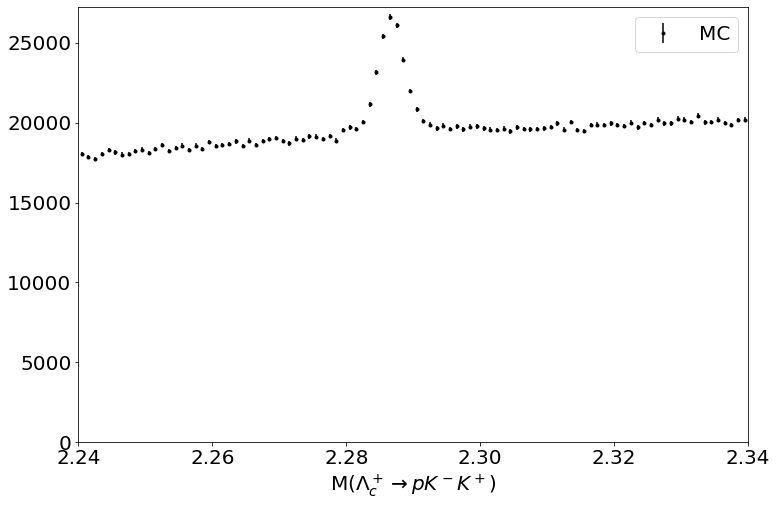

In [11]:
plotVar(sigdf,"Lambdac_M",lc_cut,mylabel=r'M($\Lambda_c^+\rightarrow p K^- K^+$)')

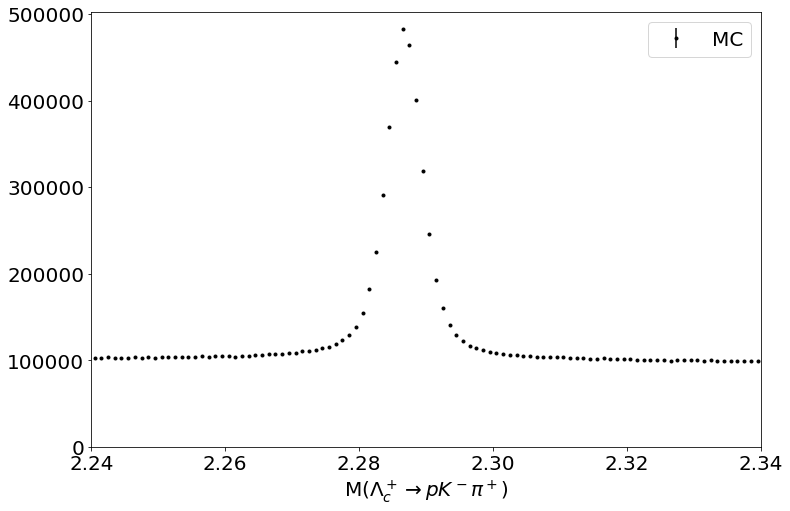

In [12]:
plotVar(ctrdf,"Lambdac_M",lc_cut,mylabel=r'M($\Lambda_c^+\rightarrow p K^- \pi^+$)')

# ZFit for $\Lambda_c^+$

In [13]:
# Define default parameters for zfit
lcrange = (llower,lupper)
lcobs = zfit.Space('Lambdac_M', lcrange)
issignal = 'Lambdac_isSignal==1'

# Get the signal and background for reference
signal = sigdf.query(lc_cut + ' and Lambdac_isSignal==1').Lambdac_M.to_numpy()
bkg = sigdf.query(lc_cut + ' and Lambdac_isSignal!=1').Lambdac_M.to_numpy()
print('signal: ' + str(len(signal)))
print('bkg: ' + str(len(bkg)))

signal: 41206
bkg: 1922921


In [14]:
# Signal fit parameters
mu = zfit.Parameter("mu", 2.289, 2.27, 2.3)
s1 = zfit.param.Parameter("s1", 0.020, 0.0001, 0.04)
s2 = zfit.param.Parameter("s2", 0.005, 0.0001, 0.04)
fg1 = zfit.param.Parameter("fg1", 0.20, 0., 1.)
a1 = zfit.Parameter("a1", 0.01, -1e6, 1e6)

# define PDFs
gaus1 = zfit.pdf.Gauss(obs=lcobs, mu=mu, sigma=s1)
gaus2 = zfit.pdf.Gauss(obs=lcobs, mu=mu, sigma=s2)
gaus = zfit.pdf.SumPDF(pdfs=[gaus1,gaus2], fracs=[fg1])

poly = zfit.pdf.Chebyshev(obs=lcobs, coeffs=[a1])
sig_yield = zfit.Parameter('sig_yield', 10000, 0, 1e9, step_size=1)
bkg_yield = zfit.Parameter('bkg_yield', 500000, 0, 1e9, step_size=1)

sig_ext = gaus.create_extended(sig_yield)
bkg_ext = poly.create_extended(bkg_yield)

pdf_ext = zfit.pdf.SumPDF(pdfs=[sig_ext,bkg_ext])

# Signal Fit for $\Lambda_c^+\$

In [15]:
# Fill an array with the data to be fit
data_np = sigdf.query(lc_cut+' and '+issignal).Lambdac_M.to_numpy()
data = zfit.data.Data.from_numpy(obs=lcobs, array=data_np)
data.set_data_range(lcrange) 
data_size = data.n_events

In [16]:
# Fix background to zero
a1.floating = False
bkg_yield.set_value(0)
bkg_yield.floating = False

# Define loss function
nll_simultaneous = zfit.loss.ExtendedUnbinnedNLL(model=pdf_ext,data=data)
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll_simultaneous)  
print(result)

FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_5, Composed_autoparam_6]] data=[<zfit.core.data.Data object at 0x7f7c40eebfa0>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | internal) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════════╡
│  True   │    True     │      False       │ 0.00015 │           -179035.86 | -35649.11 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════════╛

Parameters
name         value  (rounded)    at limit
---------  ------------------  ----------
sig_yield             41206.6       False
fg1                  0.127601       False
mu                    2.28674       False
s1                  0.0119863       False
s2                 0.00204969       False


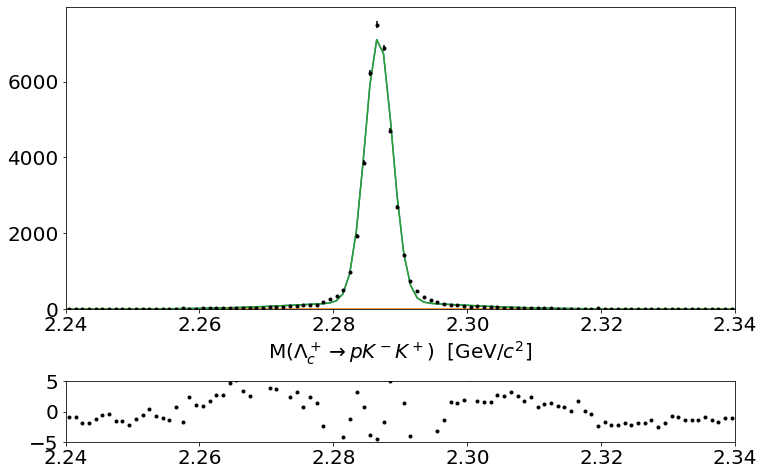

In [17]:
plot_model(model=pdf_ext, mydata=data, nevents=int(data_size), mylabel=r'M($\Lambda_c^+\rightarrow p K^- K^+$)  [GeV/$c^{2}$]')

In [18]:
# Save the signal parameters
lcsigmean=result.params[mu].get('value')
lcsigsigma1=result.params[s1].get('value')
lcsigsigma2=result.params[s2].get('value')
lcsigfg1=result.params[fg1].get('value')

print('lcsigmean =',r'%.5f' %lcsigmean)
print('lcsigsigma1 =',r'%.5f' %lcsigsigma1)
print('lcsigsigma2 =',r'%.5f' %lcsigsigma2)
print('lcsigfg1 =',r'%.5f' %lcsigfg1)

lcsigmean = 2.28674
lcsigsigma1 = 0.01199
lcsigsigma2 = 0.00205
lcsigfg1 = 0.12760


# Intergrated Fits 

## $\Lambda_c^+\rightarrow p K^- K^+\$ - signal channel intergrated fit

In [19]:
# Fill an array with the data to be fit
data_np = sigdf.query(lc_cut).Lambdac_M.to_numpy()
data = zfit.data.Data.from_numpy(obs=lcobs, array=data_np)
data.set_data_range(lcrange) 
data_size = data.n_events

In [20]:
# Float background
a1.floating = True
bkg_yield.set_value(500000)
bkg_yield.floating = True

# Fix signal shape
s1.floating = False
s1.set_value(lcsigsigma1)
s2.floating = False
s2.set_value(lcsigsigma2)
fg1.floating = False
fg1.set_value(lcsigfg1)

# Define loss function
nll_simultaneous = zfit.loss.ExtendedUnbinnedNLL(model=pdf_ext,data=data)
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll_simultaneous)  
print(result)

FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_5, Composed_autoparam_6]] data=[<zfit.core.data.Data object at 0x7f7af046bfa0>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | internal) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════════╡
│  True   │    True     │      False       │ 0.00076 │           -4527833.24 | -1118076 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════════╛

Parameters
name         value  (rounded)    at limit
---------  ------------------  ----------
sig_yield             42447.9       False
bkg_yield         1.92172e+06       False
mu                     2.2867       False
a1                  0.0581463       False


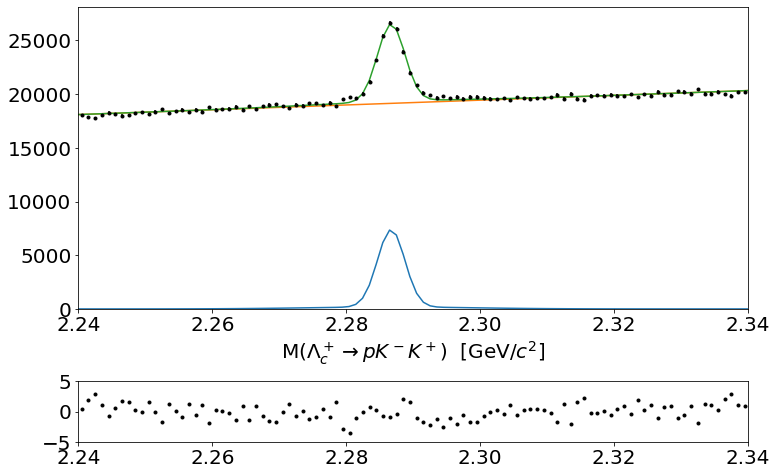

In [21]:
plot_model(model=pdf_ext, mydata=data, nevents=int(data_size), mylabel=r'M($\Lambda_c^+\rightarrow p K^- K^+$)  [GeV/$c^{2}$]')

## $\Lambda_c^+ \rightarrow pK^-\pi^+$ - control channel integrated fit

In [22]:
# Fill an array with the data to be fit
data_np = ctrdf.query(lc_cut).Lambdac_M.to_numpy()
data = zfit.data.Data.from_numpy(obs=lcobs, array=data_np)
data.set_data_range(lcrange) 
data_size = data.n_events

In [23]:
# Float background
a1.floating = True

sig_yield.set_value(700000)
sig_yield.floating = True
bkg_yield.set_value(2500000)
bkg_yield.floating = True

# Fix signal shape
s1.floating = True
s1.set_value(lcsigsigma1)
s2.floating = True
s2.set_value(lcsigsigma2)
fg1.floating = True
fg1.set_value(lcsigfg1)

# Define loss function
nll_simultaneous = zfit.loss.ExtendedUnbinnedNLL(model=pdf_ext,data=data)
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll_simultaneous)  
print(result)

FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_5, Composed_autoparam_6]] data=[<zfit.core.data.Data object at 0x7f7af03441c0>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤════════╤══════════════════════════════════╕
│  valid  │  converged  │  param at limit  │  edm   │   approx. fmin (full | internal) │
╞═════════╪═════════════╪══════════════════╪════════╪══════════════════════════════════╡
│  True   │    True     │      False       │ 0.0012 │          -31936743.88 | -8753534 │
╘═════════╧═════════════╧══════════════════╧════════╧══════════════════════════════════╛

Parameters
name         value  (rounded)    at limit
---------  ------------------  ----------
sig_yield         2.91208e+06       False
bkg_yield         1.02657e+07       False
fg1                  0.279095       False
mu                    2.28668       False
s1                 0.00721759       False
s2      

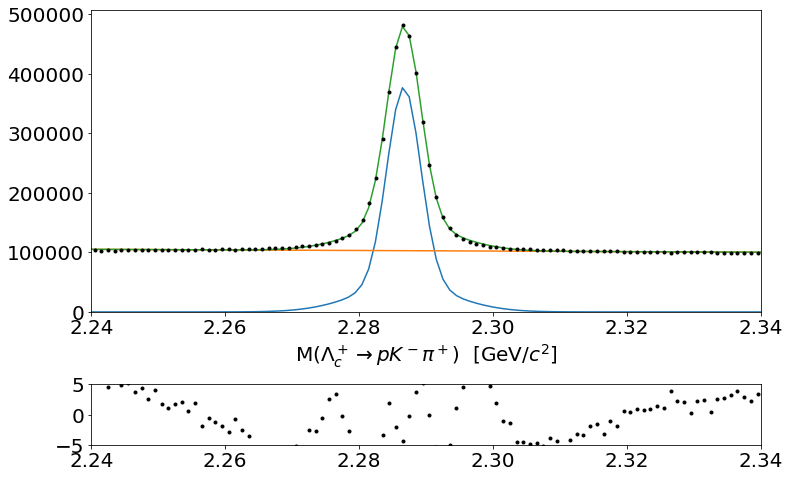

In [24]:
plot_model(model=pdf_ext, mydata=data, myrange=lcrange, nevents=int(data_size), mylabel=r'M($\Lambda_c^+\rightarrow p K^- \pi^+$)  [GeV/$c^{2}$]')

In [25]:
# Save the control parameters
lcctrmean=mu
lcctrsigma1=s1
lcctrsigma2=s2
lcctrfg1=fg1

mu.floating = False
s1.floating = False
s2.floating = False
fg1.floating = False

print('lcctrmean =',r'%.5f' %lcctrmean)
print('mu =',r'%.5f' %lcctrmean)
print('lcctrsigma1 =',r'%.5f' %lcctrsigma1)
print('lcctrsigma2 =',r'%.5f' %lcctrsigma2)
print('lcctrfg1 =',r'%.5f' %lcctrfg1)

lcctrmean = 2.28668
mu = 2.28668
lcctrsigma1 = 0.00722
lcctrsigma2 = 0.00252
lcctrfg1 = 0.27909


# Apply weights for A$_{CP}$ fit

In [26]:
# find the momentum and cos(theta) bin for each event
pkpidf_bin1 = ctrdf.query(lc_cut+" and "+bin1+' and p_charge==1')
pkpidf_bin2 = ctrdf.query(lc_cut+" and "+bin2+' and p_charge==1')
apkpidf_bin1 = ctrdf.query(lc_cut+" and "+bin1+' and p_charge==-1')
apkpidf_bin2 = ctrdf.query(lc_cut+" and "+bin2+' and p_charge==-1')

In [27]:
pkpidf_bin1

,Lambdac_M,p_trinaryID,Lambdac_cosTheta_cms,Lambdac_p_cms,Lambdac_flightDistance,p_charge,p_p,p_cosTheta,eventRandom,K_binaryID,K_p,pi_p,reWeights,Lambdac_isSignal
0,2.305369,0.999995,-0.868858,3.089007,0.025043,1.0,1.030776,-0.539102,0.313407,1.000000,0.798024,0.861073,0.015792,0.0
1,2.287129,1.000000,-0.644408,3.608584,0.019177,1.0,1.500901,-0.481737,0.027516,0.698683,1.720305,0.285974,0.016274,1.0
15,2.251863,1.000000,-0.826956,2.664949,0.002147,1.0,1.289368,-0.488094,0.682305,1.000000,1.127755,0.192456,0.016683,0.0
16,2.291511,0.999633,-0.027036,3.969390,0.003516,1.0,1.345693,0.483684,0.015773,0.989691,2.353871,0.619530,0.014622,0.0
23,2.327111,1.000000,-0.200835,3.746660,0.004800,1.0,2.738522,-0.040419,0.481320,1.000000,1.103428,0.386667,0.014925,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13177822,2.296396,1.000000,-0.475752,4.184165,0.003193,1.0,2.612797,-0.081900,0.523714,1.000000,1.254337,0.144998,0.014925,0.0
13177825,2.274843,1.000000,-0.659151,2.762080,0.013298,1.0,0.843849,-0.655061,0.981687,0.999679,1.527200,0.236735,0.013563,0.0
13177837,2.277088,1.000000,-0.587883,2.762644,0.002741,1.0,0.699292,-0.520461,0.480302,0.929232,1.288204,0.752048,0.014363,0.0
13177842,2.252780,1.000000,-0.508318,2.702332,0.001317,1.0,0.569554,-0.105775,0.155079,0.999431,1.559085,0.592859,0.010979,0.0


In [28]:
# this is a little dangerous since we replace keys with indices that depend on the order 
def getWeights(df):
    np_arr = df.to_numpy()
    return np_arr[:,0], np_arr[:,12]

In [29]:
pkpi_bin1_M, pkpi_bin1_weights = getWeights(pkpidf_bin1)
pkpi_bin2_M, pkpi_bin2_weights = getWeights(pkpidf_bin2)
apkpi_bin1_M, apkpi_bin1_weights = getWeights(apkpidf_bin1)
apkpi_bin2_M, apkpi_bin2_weights = getWeights(apkpidf_bin2)

# Fits in cos($\theta$) bins for $\Lambda_c^+\rightarrow p K^- K^+$ & $\Lambda_c^+\rightarrow p K^- \pi^+$

In [30]:
nsigtrue=[]
nasigtrue=[]
nsig=[]
nasig=[]

nsigtruee=[]
nasigtruee=[]
nsige=[]
nasige=[]

In [31]:
nctrtrue=[]
nactrtrue=[]
nctr=[]
nactr=[]

nctrtruee=[]
nactrtruee=[]
nctre=[]
nactre=[]

In [32]:
# Common shift/scale factors
smu = zfit.param.Parameter("smu", 0.0, -0.01, 0.01)
ss1 = zfit.param.Parameter("ss1", 1.0, 0., 2.5)
ss2 = zfit.param.Parameter("ss2", 1.0, 0., 2.5)

In [33]:
class LcSigGauss1(zfit.pdf.ZPDF):
    _N_OBS = 1  # dimension, can be omitted
    _PARAMS = ['mean', 'std']  # the name of the parameters

    def _unnormalized_pdf(self, x):
        x = z.unstack_x(x)  # returns a list with the columns: do x, y, z = z.unstack_x(x) for 3D
        mean = self.params['mean']
        std = self.params['std']
        return 1/(std*lcsigsigma1*np.sqrt(2*np.pi))*z.exp(- ((x - (mean+lcsigmean)) / (std*lcsigsigma1)) ** 2)

In [34]:
class LcSigGauss2(zfit.pdf.ZPDF):
    _N_OBS = 1  # dimension, can be omitted
    _PARAMS = ['mean', 'std']  # the name of the parameters

    def _unnormalized_pdf(self, x):
        x = z.unstack_x(x)  # returns a list with the columns: do x, y, z = z.unstack_x(x) for 3D
        mean = self.params['mean']
        std = self.params['std']
        return 1/(std*lcsigsigma2*np.sqrt(2*np.pi))*z.exp(- ((x - (mean+lcsigmean)) / (std*lcsigsigma2)) ** 2)

In [35]:
class LcCtrGauss1(zfit.pdf.ZPDF):
    _N_OBS = 1  # dimension, can be omitted
    _PARAMS = ['mean', 'std']  # the name of the parameters

    def _unnormalized_pdf(self, x):
        x = z.unstack_x(x)  # returns a list with the columns: do x, y, z = z.unstack_x(x) for 3D
        mean = self.params['mean']
        std = self.params['std']
        return 1/(std*lcctrsigma1*np.sqrt(2*np.pi))*z.exp(- ((x - (mean+lcctrmean)) / (std*lcctrsigma1)) ** 2)

In [36]:
class LcCtrGauss2(zfit.pdf.ZPDF):
    _N_OBS = 1  # dimension, can be omitted
    _PARAMS = ['mean', 'std']  # the name of the parameters

    def _unnormalized_pdf(self, x):
        x = z.unstack_x(x)  # returns a list with the columns: do x, y, z = z.unstack_x(x) for 3D
        mean = self.params['mean']
        std = self.params['std']
        return 1/(std*lcctrsigma2*np.sqrt(2*np.pi))*z.exp(- ((x - (mean+lcctrmean)) / (std*lcctrsigma2)) ** 2)

In [37]:
# signal fit parameters
sig_fg1 = zfit.Parameter("sig_fg1", 0.20, 0., 1.)
asig_fg1 = zfit.Parameter("asig_fg1", 0.20, 0., 1.)

sig_a1 = zfit.Parameter("sig_a1", 0.01, -1e6, 1e6)
asig_a1 = zfit.Parameter("asig_a1", 0.01, -1e6, 1e6)

# define PDFs
sig_gaus1 = LcSigGauss1(obs=lcobs, mean=smu, std=ss1)
sig_gaus2 = LcSigGauss2(obs=lcobs, mean=smu, std=ss2)
sig_gaus = zfit.pdf.SumPDF(pdfs=[sig_gaus1,sig_gaus2], fracs=[sig_fg1])

sig_poly = zfit.pdf.Chebyshev(obs=lcobs, coeffs=[sig_a1])

sig_sig_yield = zfit.Parameter('sig_sig_yield', 30000, 0, 1e8, step_size=1)
sig_bkg_yield = zfit.Parameter('sig_bkg_yield', 1000000, 0, 1e9, step_size=1)

sig_sig_ext = sig_gaus.create_extended(sig_sig_yield)
sig_bkg_ext = sig_poly.create_extended(sig_bkg_yield)

sig_pdf_ext = zfit.pdf.SumPDF(pdfs=[sig_sig_ext,sig_bkg_ext])

asig_gaus1 = LcSigGauss1(obs=lcobs, mean=smu, std=ss1)
asig_gaus2 = LcSigGauss2(obs=lcobs, mean=smu, std=ss2)
asig_gaus = zfit.pdf.SumPDF(pdfs=[asig_gaus1,asig_gaus2], fracs=[asig_fg1])

asig_poly = zfit.pdf.Chebyshev(obs=lcobs, coeffs=[asig_a1])

asig_sig_yield = zfit.Parameter('asig_sig_yield', 30000, 0, 1e8, step_size=1)
asig_bkg_yield = zfit.Parameter('asig_bkg_yield', 1000000, 0, 1e9, step_size=1)

asig_sig_ext = asig_gaus.create_extended(asig_sig_yield)
asig_bkg_ext = asig_poly.create_extended(asig_bkg_yield)

asig_pdf_ext = zfit.pdf.SumPDF(pdfs=[asig_sig_ext,asig_bkg_ext])

In [38]:
# Fit parameters
ctr_fg1 = zfit.Parameter("ctr_fg1", 0.02, 0., 1.)
actr_fg1 = zfit.Parameter("actr_fg1", 0.02, 0., 1.)

ctr_a1 = zfit.Parameter("ctr_a1", 0.01, -1e6, 1e6)
actr_a1 = zfit.Parameter("actr_a1", 0.01, -1e6, 1e6)

# define PDFs
ctr_gaus1 = LcCtrGauss1(obs=lcobs, mean=smu, std=ss1)
ctr_gaus2 = LcCtrGauss2(obs=lcobs, mean=smu, std=ss2)
ctr_gaus = zfit.pdf.SumPDF(pdfs=[ctr_gaus1,ctr_gaus2], fracs=[ctr_fg1])

ctr_poly = zfit.pdf.Chebyshev(obs=lcobs, coeffs=[ctr_a1])

ctr_sig_yield = zfit.Parameter('ctr_sig_yield', 200000, 0, 1e8, step_size=1)
ctr_bkg_yield = zfit.Parameter('ctr_bkg_yield', 600000, 0, 1e8, step_size=1)

ctr_sig_ext = ctr_gaus.create_extended(ctr_sig_yield)
ctr_bkg_ext = ctr_poly.create_extended(ctr_bkg_yield)

ctr_pdf_ext = zfit.pdf.SumPDF(pdfs=[ctr_sig_ext,ctr_bkg_ext])

actr_gaus1 = LcCtrGauss1(obs=lcobs, mean=smu, std=ss1)
actr_gaus2 = LcCtrGauss2(obs=lcobs, mean=smu, std=ss2)
actr_gaus = zfit.pdf.SumPDF(pdfs=[actr_gaus1,actr_gaus2], fracs=[actr_fg1])

actr_poly = zfit.pdf.Chebyshev(obs=lcobs, coeffs=[actr_a1])

actr_sig_yield = zfit.Parameter('actr_sig_yield', 200000, 0, 1e8, step_size=1)
actr_bkg_yield = zfit.Parameter('actr_bkg_yield', 600000, 0, 1e8, step_size=1)

actr_sig_ext = actr_gaus.create_extended(actr_sig_yield)
actr_bkg_ext = actr_poly.create_extended(actr_bkg_yield)

actr_pdf_ext = zfit.pdf.SumPDF(pdfs=[actr_sig_ext,actr_bkg_ext])

In [39]:
# Fix values from signal fit
sig_fg1.set_value(lcsigfg1)
sig_fg1.floating = False
asig_fg1.set_value(lcsigfg1)
asig_fg1.floating = False

## bin 1

In [40]:
print(bin1)

-1<=Lambdac_cosTheta_cms<0


In [41]:
# Get the signal and background for reference
sig_signal = sigdf.query(lc_cut+" and "+bin1+' and Lambdac_isSignal==1 and p_charge==1').Lambdac_M.to_numpy()
sig_bkg = sigdf.query(lc_cut+" and "+bin1+' and Lambdac_isSignal!=1 and p_charge==1').Lambdac_M.to_numpy()
print('sig signal: ' + str(len(sig_signal)))
print('sig bkg: ' + str(len(sig_bkg)))
nsigtrue.append(len(sig_signal))

asig_signal = sigdf.query(lc_cut+" and "+bin1+' and Lambdac_isSignal==1 and p_charge==-1').Lambdac_M.to_numpy()
asig_bkg = sigdf.query(lc_cut+" and "+bin1+' and Lambdac_isSignal!=1 and p_charge==-1').Lambdac_M.to_numpy()
print('asig signal: ' + str(len(asig_signal)))
print('asig bkg: ' + str(len(asig_bkg)))
nasigtrue.append(len(asig_signal))

# Get the signal and background for reference
ctr_signal = ctrdf.query(lc_cut+" and "+bin1+' and Lambdac_isSignal==1 and p_charge==1').Lambdac_M.to_numpy()
ctr_bkg = ctrdf.query(lc_cut+" and "+bin1+' and Lambdac_isSignal!=1 and p_charge==1').Lambdac_M.to_numpy()
print('ctr signal: ' + str(len(ctr_signal)))
print('ctr bkg: ' + str(len(ctr_bkg)))
nctrtrue.append(len(ctr_signal))

actr_signal = ctrdf.query(lc_cut+" and "+bin1+' and Lambdac_isSignal==1 and p_charge==-1').Lambdac_M.to_numpy()
actr_bkg = ctrdf.query(lc_cut+" and "+bin1+' and Lambdac_isSignal!=1 and p_charge==-1').Lambdac_M.to_numpy()
print('actr signal: ' + str(len(actr_signal)))
print('actr bkg: ' + str(len(actr_bkg)))
nactrtrue.append(len(actr_signal))

sig signal: 11166
sig bkg: 445152
asig signal: 10338
asig bkg: 421214
ctr signal: 802407
ctr bkg: 2427827
actr signal: 742229
actr bkg: 2302017


In [42]:
# Fill an array with the data to be fit
sig_data_np = sigdf.query(lc_cut+" and "+bin1+' and p_charge==1').Lambdac_M.to_numpy()
sig_data = zfit.data.Data.from_numpy(obs=lcobs, array=sig_data_np)
sig_data.set_data_range(lcrange)
sig_data_size = sig_data.n_events

asig_data_np = sigdf.query(lc_cut+" and "+bin1+' and p_charge==-1').Lambdac_M.to_numpy()
asig_data = zfit.data.Data.from_numpy(obs=lcobs, array=asig_data_np)
asig_data.set_data_range(lcrange)
asig_data_size = asig_data.n_events

#ctr_data_np = ctrdf.query(lc_cut+" and "+bin1+' and p_charge==1').Lambdac_M.to_numpy()
ctr_data_np = pkpi_bin1_M #weighted mass
ctr_data = zfit.data.Data.from_numpy(obs=lcobs, array=ctr_data_np, weights=pkpi_bin1_weights)
ctr_data.set_data_range(lcrange)
ctr_data_size = ctr_data.n_events

#actr_data_np = ctrdf.query(lc_cut+" and "+bin1+' and p_charge==-1').Lambdac_M.to_numpy()
actr_data_np = apkpi_bin1_M #weighted mass
actr_data = zfit.data.Data.from_numpy(obs=lcobs, array=actr_data_np, weights=apkpi_bin1_weights)
actr_data.set_data_range(lcrange)
actr_data_size = actr_data.n_events

print(int(sig_data_size))
print(int(asig_data_size))
print(int(ctr_data_size))
print(int(actr_data_size))

456318
431552
3230234
3044246


In [43]:
# Simultaenous loss
nll_simultaneous = zfit.loss.ExtendedUnbinnedNLL(model=[sig_pdf_ext,asig_pdf_ext,ctr_pdf_ext,actr_pdf_ext], data=[sig_data,asig_data,ctr_data,actr_data])
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll_simultaneous)

In [44]:
result.hesse()
errors, new_result = result.errors()
print(result)

/home/belle2/dhettiar/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1204: ChangedFeatureWarning: The behavior of this functionality recently changed.To turn this warning off, use `zfit.settings.changed_warnings.hesse_name = False`  or 'all' with `zfit.settings.changed_warnings.all = False
Default name of hesse (which is currently the method name such as `minuit_hesse`or `hesse_np`) has changed to `hesse` (it still adds the old one as well. This will be removed in the future). INSTRUCTIONS: to stay compatible,  change wherever you access the error to 'hesse' (if you don't explicitly specify the name in hesse(...).
  warn_changed_feature(message, "hesse_name")
/home/belle2/dhettiar/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as

FitResult of
<ExtendedUnbinnedNLL model=multiple data=multiple constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤════════╤══════════════════════════════════╕
│  valid  │  converged  │  param at limit  │  edm   │   approx. fmin (full | internal) │
╞═════════╪═════════════╪══════════════════╪════════╪══════════════════════════════════╡
│  True   │    True     │      False       │ 0.0011 │           -2268249.18 | -1668919 │
╘═════════╧═════════════╧══════════════════╧════════╧══════════════════════════════════╛

Parameters
name              value  (rounded)        hesse               errors         minuit_minos    at limit
--------------  ------------------  -----------  -------------------  -------------------  ----------
sig_sig_yield              10755.2  +/- 2.5e+02  -2.6e+02   +2.5e+02  -2.6e+02   +2.5e+02       False
sig_bkg_yield               445563  +/- 2.5e+02  -  7e+02   +7.1e+02  -  7e+02   +7.1e+02       False
smu                   -

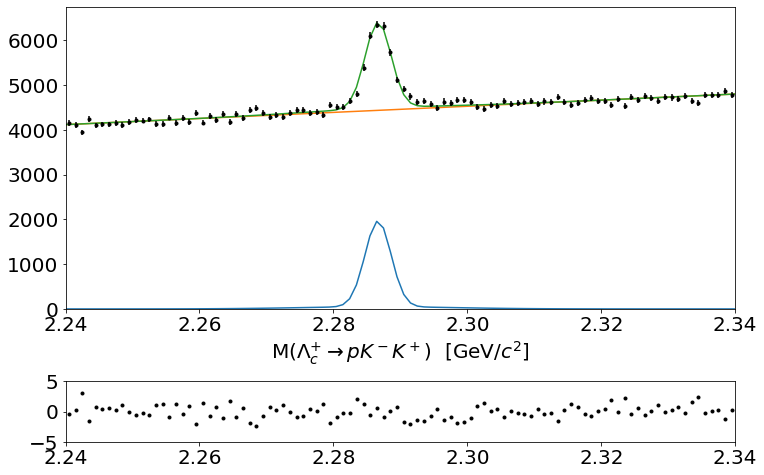

In [45]:
plot_model(model=sig_pdf_ext, mydata=sig_data, nevents=int(sig_data_size), mylabel=r'M($\Lambda_{c}^{+}\rightarrow p K^- K^+$)  [GeV/$c^{2}$]')

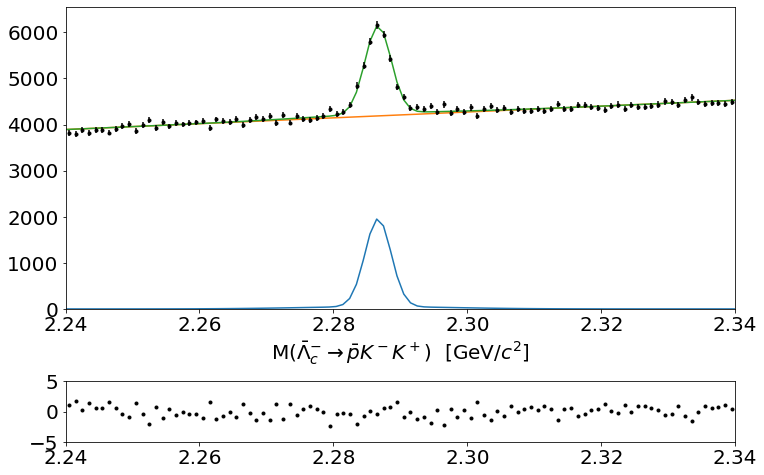

In [46]:
plot_model(model=asig_pdf_ext, mydata=asig_data, nevents=int(asig_data_size), mylabel=r'M($\bar{\Lambda}_{c}^{-}\rightarrow \barp K^- K^+$)  [GeV/$c^{2}$]')

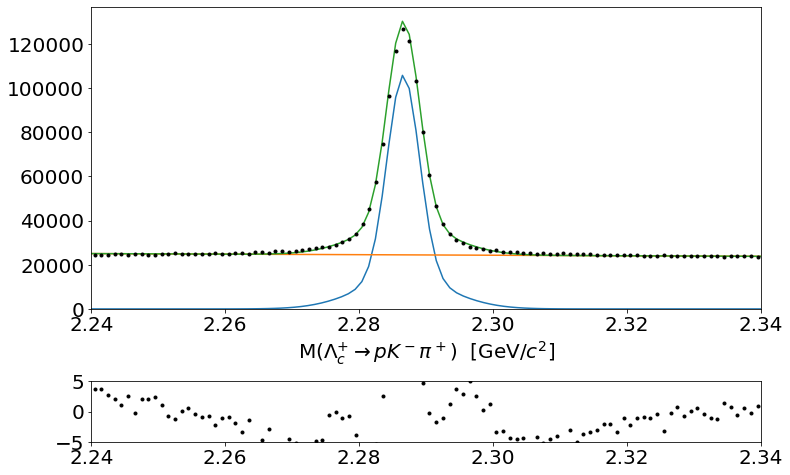

In [47]:
plot_model(model=ctr_pdf_ext, mydata=ctr_data, nevents=int(ctr_data_size), mylabel=r'M($\Lambda_{c}^{+}\rightarrow p K^- \pi^+$)  [GeV/$c^{2}$]')

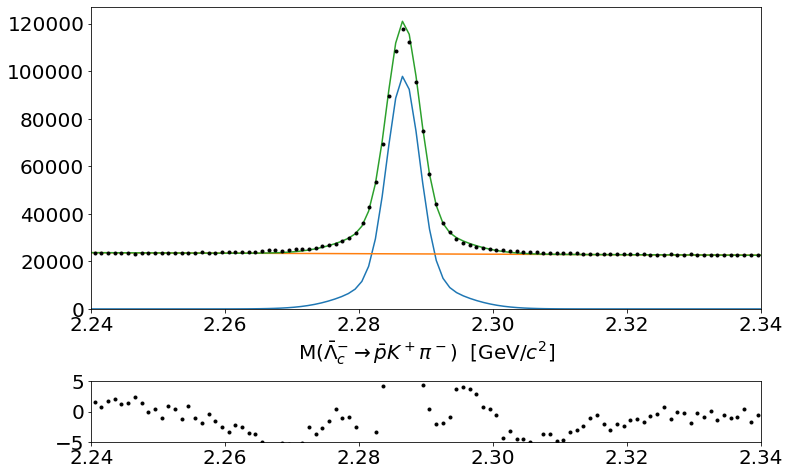

In [48]:
plot_model(model=actr_pdf_ext, mydata=actr_data, nevents=int(actr_data_size), mylabel=r'M($\bar{\Lambda}_{c}^{-}\rightarrow \barp K^+ \pi^-$)  [GeV/$c^{2}$]')

In [49]:
nsig.append(result.params[sig_sig_yield].get('value'))
nsige.append(result.params[sig_sig_yield].get('hesse').get('error'))
nasig.append(result.params[asig_sig_yield].get('value'))
nasige.append(result.params[asig_sig_yield].get('hesse').get('error'))

nctr.append(result.params[ctr_sig_yield].get('value'))
nctre.append(result.params[ctr_sig_yield].get('hesse').get('error'))
nactr.append(result.params[actr_sig_yield].get('value'))
nactre.append(result.params[actr_sig_yield].get('hesse').get('error'))

## bin 2

In [50]:
print(bin2)

0<=Lambdac_cosTheta_cms<1


In [51]:
# Get the signal and background for reference
sig_signal = sigdf.query(lc_cut+" and "+bin2+' and Lambdac_isSignal==1 and p_charge==1').Lambdac_M.to_numpy()
sig_bkg = sigdf.query(lc_cut+" and "+bin2+' and Lambdac_isSignal!=1 and p_charge==1').Lambdac_M.to_numpy()
print('sig signal: ' + str(len(sig_signal)))
print('sig bkg: ' + str(len(sig_bkg)))
nsigtrue.append(len(sig_signal))

asig_signal = sigdf.query(lc_cut+" and "+bin2+' and Lambdac_isSignal==1 and p_charge==-1').Lambdac_M.to_numpy()
asig_bkg = sigdf.query(lc_cut+" and "+bin2+' and Lambdac_isSignal!=1 and p_charge==-1').Lambdac_M.to_numpy()
print('asig signal: ' + str(len(asig_signal)))
print('asig bkg: ' + str(len(asig_bkg)))
nasigtrue.append(len(asig_signal))

# Get the signal and background for reference
ctr_signal = ctrdf.query(lc_cut+" and "+bin2+' and Lambdac_isSignal==1 and p_charge==1').Lambdac_M.to_numpy()
ctr_bkg = ctrdf.query(lc_cut+" and "+bin2+' and Lambdac_isSignal!=1 and p_charge==1').Lambdac_M.to_numpy()
print('ctr signal: ' + str(len(ctr_signal)))
print('ctr bkg: ' + str(len(ctr_bkg)))
nctrtrue.append(len(ctr_signal))

actr_signal = ctrdf.query(lc_cut+" and "+bin2+' and Lambdac_isSignal==1 and p_charge==-1').Lambdac_M.to_numpy()
actr_bkg = ctrdf.query(lc_cut+" and "+bin2+' and Lambdac_isSignal!=1 and p_charge==-1').Lambdac_M.to_numpy()
print('actr signal: ' + str(len(actr_signal)))
print('actr bkg: ' + str(len(actr_bkg)))
nactrtrue.append(len(actr_signal))

sig signal: 10238
sig bkg: 534230
asig signal: 9464
asig bkg: 522325
ctr signal: 757909
ctr bkg: 2755178
actr signal: 726991
actr bkg: 2663287


In [52]:
# Fill an array with the data to be fit
sig_data_np = sigdf.query(lc_cut+" and "+bin2+' and p_charge==1').Lambdac_M.to_numpy()
sig_data = zfit.data.Data.from_numpy(obs=lcobs, array=sig_data_np)
sig_data.set_data_range(lcrange)
sig_data_size = sig_data.n_events

asig_data_np = sigdf.query(lc_cut+" and "+bin2+' and p_charge==-1').Lambdac_M.to_numpy()
asig_data = zfit.data.Data.from_numpy(obs=lcobs, array=asig_data_np)
asig_data.set_data_range(lcrange)
asig_data_size = asig_data.n_events

#ctr_data_np = ctrdf.query(lc_cut+" and "+bin2+' and p_charge==1').Lambdac_M.to_numpy()
ctr_data_np = pkpi_bin2_M #weighted mass
ctr_data = zfit.data.Data.from_numpy(obs=lcobs, array=ctr_data_np, weights=pkpi_bin2_weights)

ctr_data.set_data_range(lcrange)
ctr_data_size = ctr_data.n_events

#actr_data_np = ctrdf.query(lc_cut+" and "+bin2+' and p_charge==-1').Lambdac_M.to_numpy()
actr_data_np = apkpi_bin2_M
actr_data = zfit.data.Data.from_numpy(obs=lcobs, array=actr_data_np, weights=apkpi_bin2_weights)
actr_data.set_data_range(lcrange)
actr_data_size = actr_data.n_events

print(int(sig_data_size))
print(int(asig_data_size))
print(int(ctr_data_size))
print(int(actr_data_size))

544468
531789
3513087
3390278


In [53]:
# Simultaenous loss
nll_simultaneous = zfit.loss.ExtendedUnbinnedNLL(model=[sig_pdf_ext,asig_pdf_ext,ctr_pdf_ext,actr_pdf_ext], data=[sig_data,asig_data,ctr_data,actr_data])
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll_simultaneous)

In [54]:
result.hesse()
errors, new_result = result.errors()
print(result)

/home/belle2/dhettiar/.local/lib/python3.8/site-packages/zfit/minimizers/fitresult.py:1340: FutureWarning: 'minuit_minos' will be changed as the default errors method to a custom implementationwith the same functionality. If you want to make sure that 'minuit_minos' will be used in the future, add it explicitly as in `errors(method='minuit_minos')`
  warnings.warn(


FitResult of
<ExtendedUnbinnedNLL model=multiple data=multiple constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | internal) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════════╡
│  True   │    True     │      False       │ 0.00055 │          -2711502.10 | -9512.701 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════════╛

Parameters
name              value  (rounded)        hesse               errors         minuit_minos    at limit
--------------  ------------------  -----------  -------------------  -------------------  ----------
sig_sig_yield              10582.2  +/- 2.7e+02  -2.8e+02   +2.9e+02  -2.8e+02   +2.9e+02       False
sig_bkg_yield               533893  +/- 2.7e+02  -7.8e+02   +7.7e+02  -7.8e+02   +7.7e+02       False
smu               

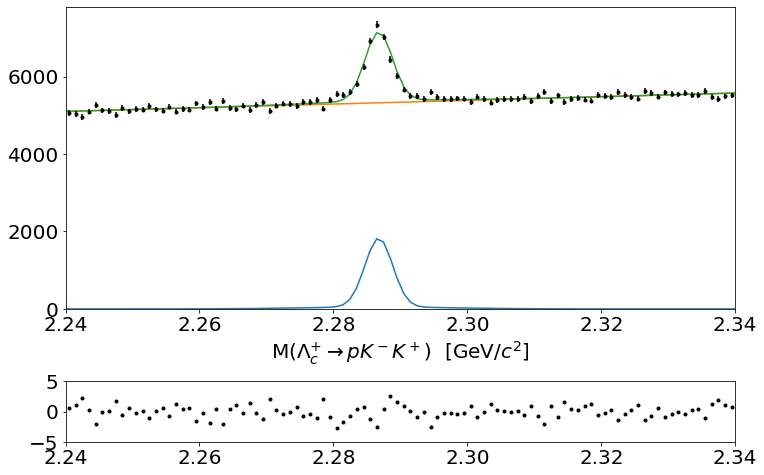

In [55]:
plot_model(model=sig_pdf_ext, mydata=sig_data, nevents=int(sig_data_size), mylabel=r'M($\Lambda_{c}^{+}\rightarrow p K^- K^+$)  [GeV/$c^{2}$]')

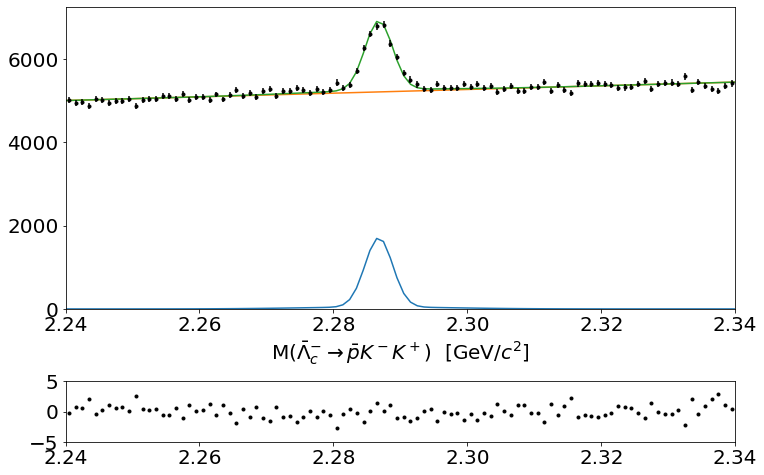

In [56]:
plot_model(model=asig_pdf_ext, mydata=asig_data, nevents=int(asig_data_size), mylabel=r'M($\bar\Lambda_{c}^{-}\rightarrow \barp K^- K^+$)  [GeV/$c^{2}$]')

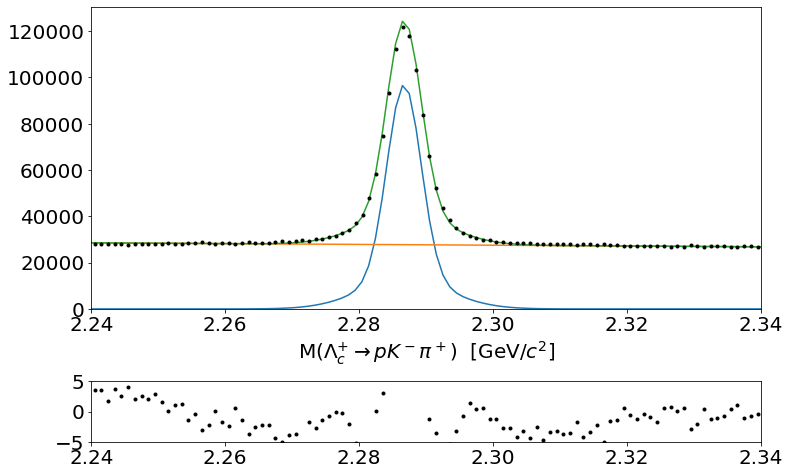

In [57]:
plot_model(model=ctr_pdf_ext, mydata=ctr_data, nevents=int(ctr_data_size), mylabel=r'M($\Lambda_{c}^{+}\rightarrow p K^- \pi^+$)  [GeV/$c^{2}$]')

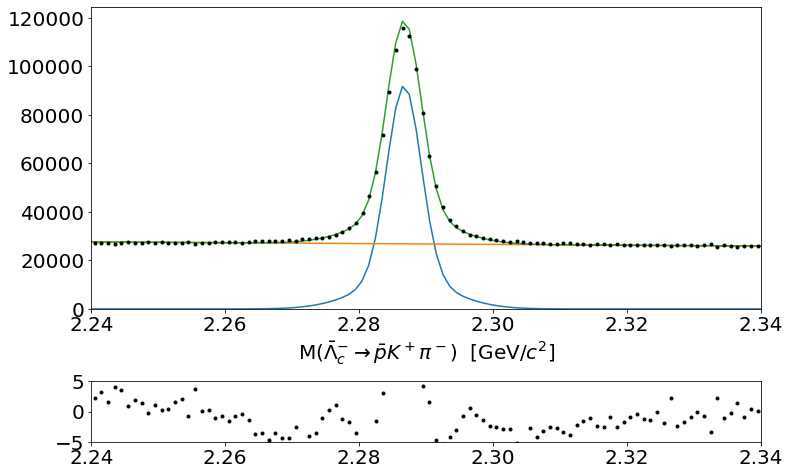

In [58]:
plot_model(model=actr_pdf_ext, mydata=actr_data, nevents=int(actr_data_size), mylabel=r'M($\bar\Lambda_{c}^{-}\rightarrow \barp K^+ \pi^-$)  [GeV/$c^{2}$]')

In [59]:
nsig.append(result.params[sig_sig_yield].get('value'))
nsige.append(result.params[sig_sig_yield].get('hesse').get('error'))
nasig.append(result.params[asig_sig_yield].get('value'))
nasige.append(result.params[asig_sig_yield].get('hesse').get('error'))

nctr.append(result.params[ctr_sig_yield].get('value'))
nctre.append(result.params[ctr_sig_yield].get('hesse').get('error'))
nactr.append(result.params[actr_sig_yield].get('value'))
nactre.append(result.params[actr_sig_yield].get('hesse').get('error'))

In [60]:
print(nsigtrue)
print(nsig)
print(nasigtrue)
print(nasig)

print(nctrtrue)
print(nctr)
print(nactrtrue)
print(nactr)

[11166, 10238]
[10755.238467902633, 10582.174906166423]
[10338, 9464]
[10722.709277914633, 9887.680475444233]
[802407, 757909]
[11333.35811763202, 10299.47341402243]
[742229, 726991]
[10485.762202446134, 9862.466088242943]


In [61]:
import uncertainties as un
from uncertainties import unumpy

In [62]:
sigar = unumpy.uarray(nsig,nsige)
asigar = unumpy.uarray(nasig,nasige)
ctrar = unumpy.uarray(nctr,nctre)
actrar = unumpy.uarray(nactr,nactre)

In [63]:
print(asigar)
print(asigar)
print(ctrar)
print(actrar)

[10722.709277914633+/-242.80974006457413
 9887.680475444233+/-273.16927067443476]
[10722.709277914633+/-242.80974006457413
 9887.680475444233+/-273.16927067443476]
[11333.35811763202+/-44.195214817263306
 10299.47341402243+/-32.617987223118604]
[10485.762202446134+/-39.69608615769753
 9862.466088242943+/-33.501323740120405]


In [64]:
nsigtruee = np.sqrt(nsigtrue)
nasigtruee = np.sqrt(nasigtrue)
nctrtruee = np.sqrt(nctrtrue)
nactrtruee = np.sqrt(nactrtrue)

In [65]:
print(nsigtruee)
print(nasigtruee)
print(nctrtruee)
print(nactrtruee)

[105.66929545 101.18300253]
[101.67595586  97.28309206]
[895.77173432 870.57969193]
[861.52713248 852.63767217]


In [66]:
trsigar = unumpy.uarray(nsigtrue,nsigtruee)
trasigar = unumpy.uarray(nasigtrue,nasigtruee)
trctrar = unumpy.uarray(nctrtrue,nctrtruee)
tractrar = unumpy.uarray(nactrtrue,nactrtruee)

In [67]:
print(trsigar)
print(trasigar)
print(trctrar)
print(tractrar)

[11166.0+/-105.66929544574431 10238.0+/-101.1830025251277]
[10338.0+/-101.67595585978034 9464.0+/-97.28309205612247]
[802407.0+/-895.7717343162822 757909.0+/-870.5796919294637]
[742229.0+/-861.5271324804577 726991.0+/-852.6376721679613]


# Apply weights for true A$_{CP}$

In [68]:
# find the momentum and cos(theta) bin for each event
pkpidf_bin1_true = ctrdf.query(lc_cut+" and "+bin1+' and Lambdac_isSignal==1 and p_charge==1')
pkpidf_bin2_true = ctrdf.query(lc_cut+" and "+bin2+' and Lambdac_isSignal==1 and p_charge==1')
apkpidf_bin1_true = ctrdf.query(lc_cut+" and "+bin1+' and Lambdac_isSignal==1 and p_charge==-1')
apkpidf_bin2_true = ctrdf.query(lc_cut+" and "+bin2+' and Lambdac_isSignal==1 and p_charge==-1')

In [69]:
pkpidf_bin1_true

,Lambdac_M,p_trinaryID,Lambdac_cosTheta_cms,Lambdac_p_cms,Lambdac_flightDistance,p_charge,p_p,p_cosTheta,eventRandom,K_binaryID,K_p,pi_p,reWeights,Lambdac_isSignal
1,2.287129,1.000000,-0.644408,3.608584,0.019177,1.0,1.500901,-0.481737,0.027516,0.698683,1.720305,0.285974,0.016274,1.0
28,2.285403,1.000000,-0.537556,3.326449,0.005322,1.0,1.706852,-0.105214,0.346328,1.000000,1.305831,0.333276,0.014149,1.0
30,2.282362,0.997351,-0.734603,2.654418,0.014009,1.0,1.422275,-0.647311,0.335638,1.000000,0.837694,0.436336,0.013772,1.0
33,2.279593,0.941601,-0.675955,2.762463,0.000410,1.0,1.694626,-0.696450,0.207830,0.999887,0.730877,0.353703,0.014218,1.0
47,2.287353,1.000000,-0.595621,3.048094,0.006885,1.0,1.258059,-0.385765,0.793867,1.000000,0.811347,0.975767,0.014576,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12859742,2.256682,1.000000,-0.574860,4.064600,0.006162,1.0,1.660200,-0.188943,0.773243,0.663490,1.478437,0.594587,0.013663,1.0
12859747,2.280860,0.999537,-0.630090,3.726795,0.002019,1.0,1.015961,-0.638788,0.445317,0.998819,2.084105,0.430204,0.014346,1.0
12859750,2.285115,0.998625,-0.093050,3.386702,0.013373,1.0,1.910432,0.438321,0.141026,1.000000,0.548139,1.239654,0.015523,1.0
13063068,2.286499,1.000000,-0.666583,2.656008,0.005835,1.0,0.976190,0.328482,0.089757,0.543722,1.128096,0.610688,0.013383,1.0


In [70]:
pkpi_bin1_M_true, pkpi_bin1_weights_true = getWeights(pkpidf_bin1_true)
pkpi_bin2_M_true, pkpi_bin2_weights_true = getWeights(pkpidf_bin2_true)
apkpi_bin1_M_true, apkpi_bin1_weights_true = getWeights(apkpidf_bin1_true)
apkpi_bin2_M_true, apkpi_bin2_weights_true = getWeights(apkpidf_bin2_true)

In [71]:
nctrweighted=[]
nactrweighted=[]

In [72]:
# Get the weighted true Acp value
ctr_signal = (ctrdf.query(lc_cut+" and "+bin1+' and Lambdac_isSignal==1 and p_charge==1')['Lambdac_M'] * pkpi_bin1_weights_true).to_numpy()
actr_signal = (ctrdf.query(lc_cut+" and "+bin1+' and Lambdac_isSignal==1 and p_charge==-1')['Lambdac_M'] * apkpi_bin1_weights_true).to_numpy()
nctrweighted.append(np.sum(ctr_signal))
nactrweighted.append(np.sum(actr_signal))


ctr_signal = (ctrdf.query(lc_cut+" and "+bin2+' and Lambdac_isSignal==1 and p_charge==1')['Lambdac_M'] * pkpi_bin2_weights_true).to_numpy()
actr_signal = (ctrdf.query(lc_cut+" and "+bin2+' and Lambdac_isSignal==1 and p_charge==-1')['Lambdac_M'] * apkpi_bin2_weights_true).to_numpy()
nctrweighted.append(np.sum(ctr_signal))
nactrweighted.append(np.sum(actr_signal))
    
nctrweightede = np.sqrt(nctrweighted)
nactrweightede = np.sqrt(nactrweighted)
    
trctrwar = unumpy.uarray(nctrweighted,nctrweightede)
tractrwar = unumpy.uarray(nactrweighted,nactrweightede)

# A$_{CP}$ Determination

In [73]:
def getAsym(sig,asig,ctr,actr):
    a1 = ((sig[0]-asig[0])/(sig[0]+asig[0])+(sig[1]-asig[1])/(sig[1]+asig[1]))/2
          
    a2 = ((ctr[0]-actr[0])/(ctr[0]+actr[0])+(ctr[1]-actr[1])/(ctr[1]+actr[1]))/2
     
    acp = a1-a2     
    
    return a1, a2, acp

In [74]:
getAsym(trsigar,trasigar,trctrar,tractrar) #True Acp Values

(0.03889490801332715+/-0.004927270173365769,
 0.02989047236546684+/-0.0005743633715048388,
 0.009004435647860312+/-0.004960633492192942)

In [75]:
getAsym(trsigar,trasigar,trctrwar,tractrwar) #True Weighted Acp

(0.03889490801332715+/-0.004927270173365769,
 0.030067068704228525+/-0.0031596029927824514,
 0.008827839309098626+/-0.005853296714958141)

In [76]:
getAsym(sigar,asigar,ctrar,actrar) #Weighted Fit Acp Values

(0.017721102859815457+/-0.012341518425957725,
 0.030260670293633753+/-0.0017853068638084895,
 -0.012539567433818295+/-0.01246997985789134)

In [77]:
print(sigar-trsigar)

[-410.7615320973673+/-266.9848742694921
 344.17490616642317+/-287.07862473416856]


In [78]:
print(ctrar-trctrar)

[-791073.641882368+/-896.8613142580875
 -747609.5265859775+/-871.1905262860056]
